# Time Series - Forecasting example

###### Links: [Sales dataset (Kaggle)](https://www.kaggle.com/c/competitive-data-science-predict-future-sales)  |  [Article 1 (TowardsDataScience)](https://medium.com/@m.dipietro09/time-series-analysis-for-machine-learning-with-python-626bee0d0205)  |  [Article 2 (AnalyticsVidhya)](https://medium.com/analytics-vidhya/time-series-forecasting-with-random-walk-58e84c93058b)  |  [Article 3 (AnalyticsVidhya)](https://medium.com/analytics-vidhya/time-series-forecasting-arima-vs-lstm-vs-prophet-62241c203a3b) 

### 0 - Setup

###### Import pckgs 

In [3]:
import warnings
warnings.filterwarnings("ignore")
from ts_utils import *

###### Import data

In [2]:
dtf = pd.read_csv('data_sales.csv')
dtf.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
dtf["date"] = pd.to_datetime(dtf['date'], format='%d.%m.%Y')

In [4]:
ts = dtf.groupby("date")["item_cnt_day"].sum().rename("sales")
ts.head()

date
2013-01-01    1951.0
2013-01-02    8198.0
2013-01-03    7422.0
2013-01-04    6617.0
2013-01-05    6346.0
Name: sales, dtype: float64

In [5]:
ts.tail()

date
2015-10-27    1551.0
2015-10-28    3593.0
2015-10-29    1589.0
2015-10-30    2274.0
2015-10-31    3104.0
Name: sales, dtype: float64

### 1 - TimeSeries Analysis

###### Check for:
- Trend 
- Level
- Outliers
- Stationarity
- Seasonality (define s)

###### Target Variable

In [6]:
print("population --> len:", len(ts), "| mean:", round(ts.mean()), " | std:", round(ts.std()))
w = 30
print("moving --> len:", w, " | mean:", round(ts.ewm(span=w).mean()[-1]), " | std:", round(ts.ewm(span=w).std()[-1]))

population --> len: 1034 | mean: 3528.0  | std: 1585.0
moving --> len: 30  | mean: 2305.0  | std: 773.0


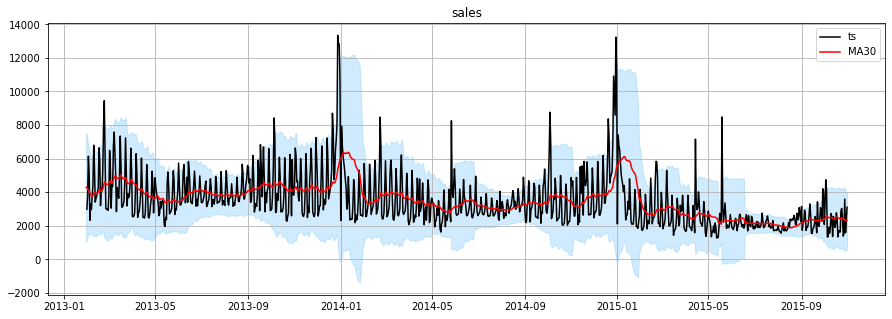

In [7]:
plot_ts(ts, plot_ma=True, plot_intervals=True, window=w, figsize=(15,5))

###### Trend

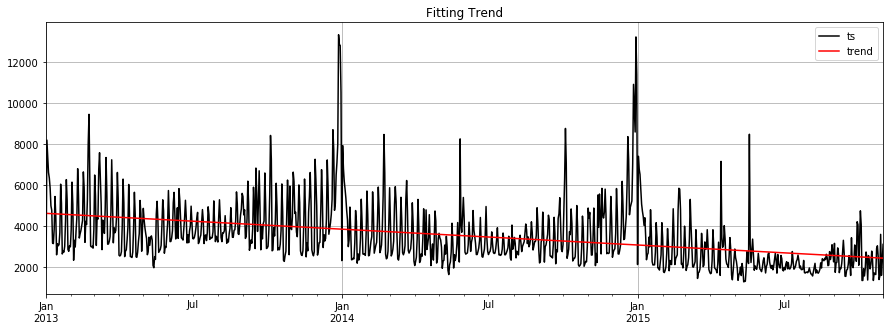

In [8]:
trend, line = fit_trend(ts, degree=1, plot=True, figsize=(15,5))

In [96]:
# -> There is a slight trend and it's linear ("additive")
print("constant:", round(line[-1],2), "| slope:", round(line[0],2))

constant: 4622.02 | slope: -2.12


###### Level

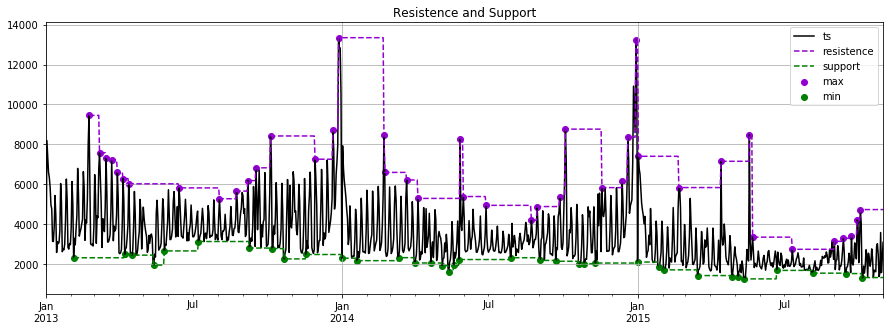

In [7]:
res_sup = resistence_support(ts, window=30, trend=False, plot=True, figsize=(15,5))

In [ ]:
# -> okay

###### Outliers

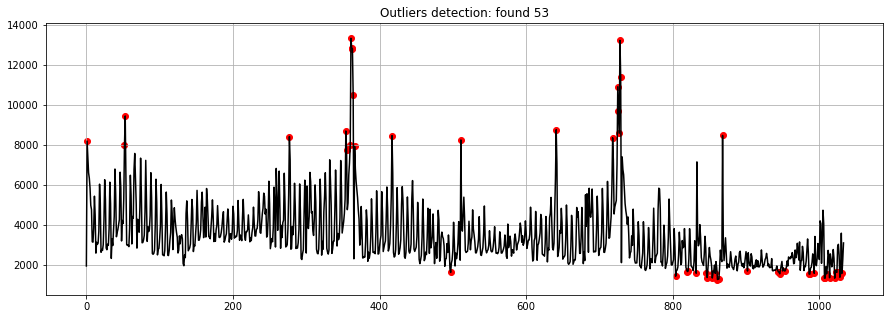

In [9]:
dtf_outliers = find_outliers(ts, perc=0.05, figsize=(15,5))

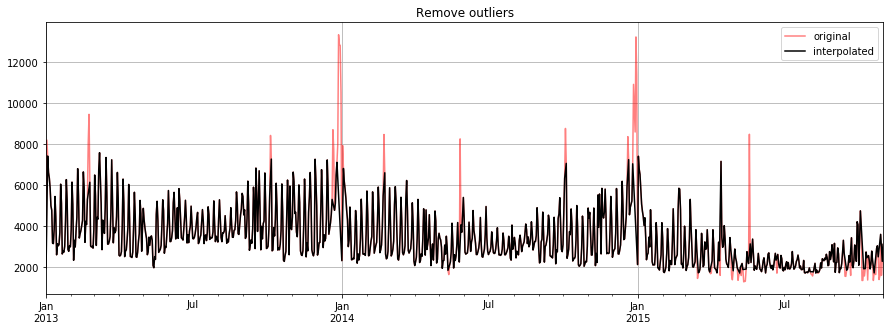

In [10]:
ts_clean = remove_outliers(ts, outliers_idx=dtf_outliers[dtf_outliers["outlier"]==1].index, figsize=(15,5))

In [12]:
# -> I will keep the outliers.

###### Stationarity

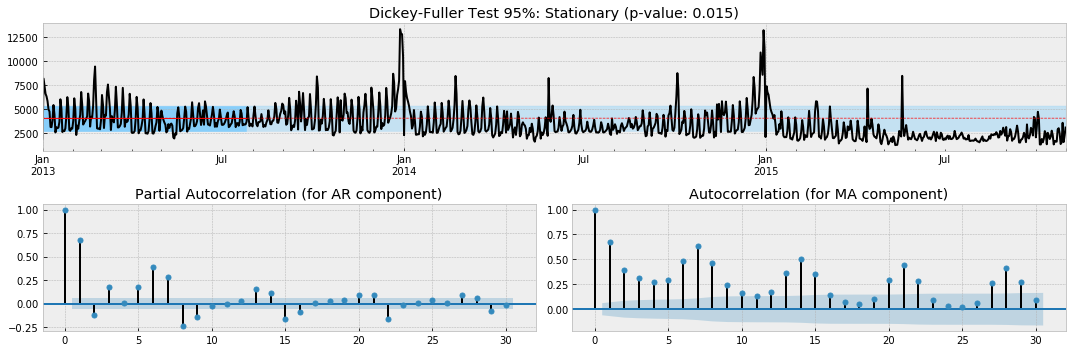

In [11]:
test_stationarity_acf_pacf(ts, sample=0.20, maxlag=w, figsize=(15,5))

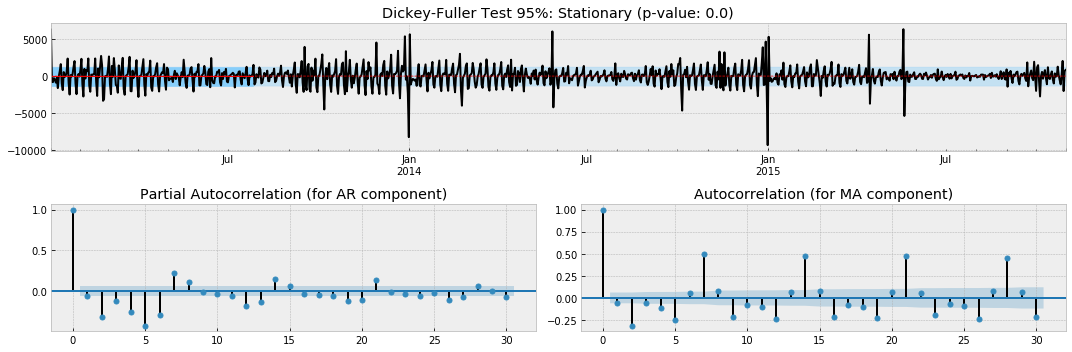

In [12]:
# I'm not sure: the test says it's stationary but it doesn't look like, let's try with differentiating the ts
test_stationarity_acf_pacf(diff_ts(ts, order=1), sample=0.20, maxlag=30, figsize=(15,5))

In [15]:
# CLearly there is stationarity every 2 days (negative: at the beginning of the week less sales) 
# and 7 days (positive: more sales on the weekend)
# -> I will use the raw ts.

###### Seasonality

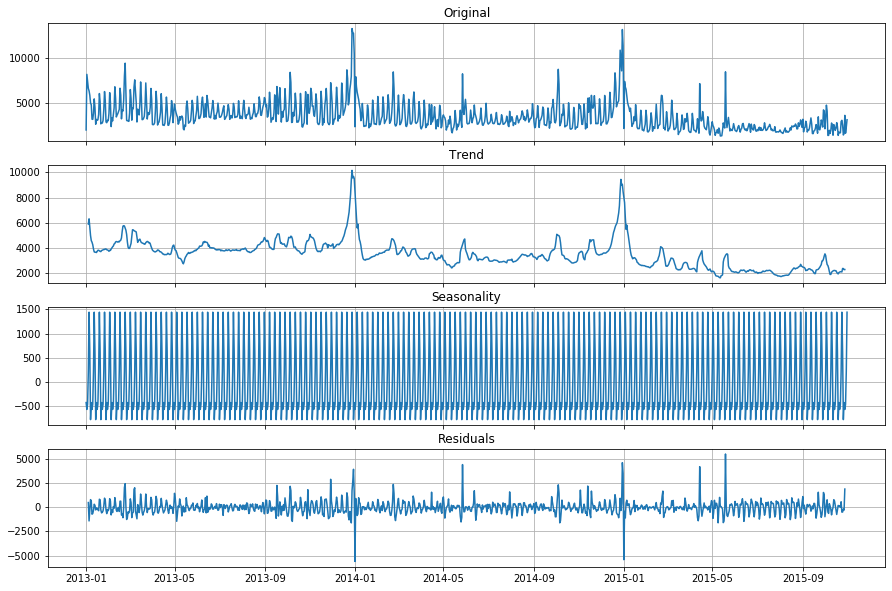

In [16]:
dic_decomposed = decompose_ts(ts, s=7, figsize=(15,10))

In [15]:
# -> Using weekly seasonality there are smaller residuals
s = 7

### 2 - Preprocessing

###### Differenciating

In [12]:
# I will use the raw ts

###### Partitioning

--- splitting at index:  881 | 2015-06-01 00:00:00 | test size: 0.15  ---


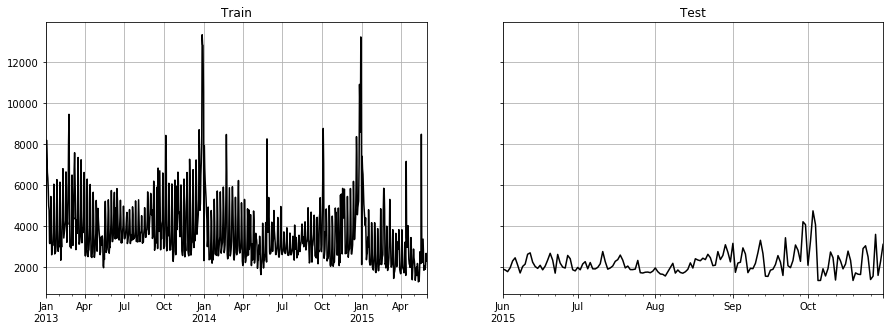

train: 881 obs  |  test: 153 obs


In [8]:
ts_train, ts_test = split_train_test(ts, exog=None, test="2015-06-01", plot=True, figsize=(15,5))
print("train:", len(ts_train), "obs  |  test:", len(ts_test), "obs")

### 3 - Baseline (Random Walk)

###### Train/Test

--- computing confidence interval ---


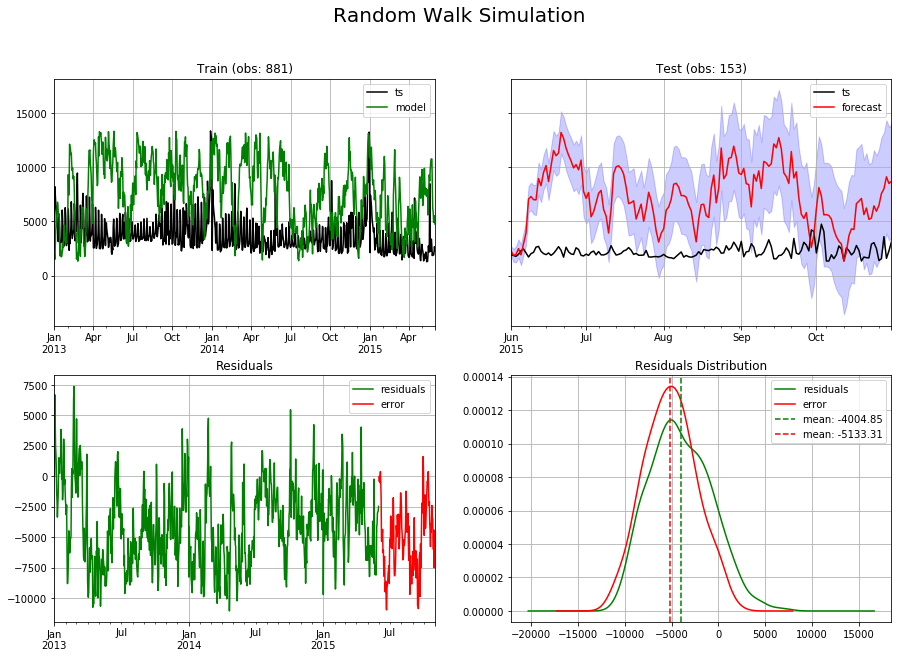

Training --> Residuals mean: -4005.0  | std: 3266.0
Test --> Error mean: -5133.0  | std: 2714.0  | mae: 5170.0  | mape: 250.0 %  | mse: 33668847.0  | rmse: 5802.0


In [12]:
dtf = simulate_rw(ts_train, ts_test, conf=0.10, figsize=(15,10))

In [21]:
#-> Totally random, really bad. So the series is not random, there's autocorrelation.

###### Forecast unknown

--- generating index date --> start: 2015-11-01 00:00:00 | end: 2016-01-01 00:00:00 | len: 62 ---
--- computing confidence interval ---


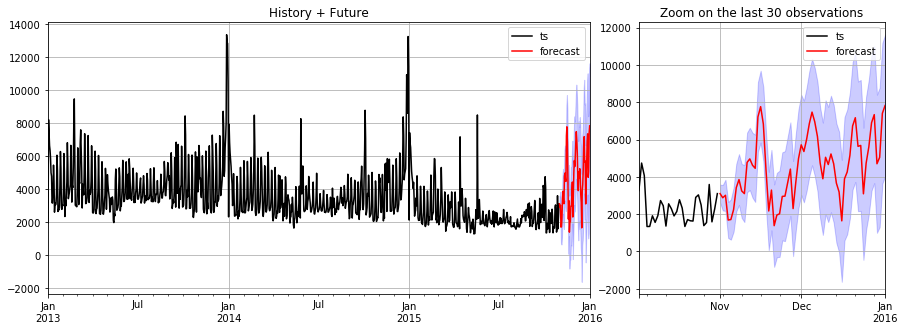

In [17]:
future = forecast_rw(ts, end="2016-01-01", conf=0.10, zoom=30, figsize=(15,5))

In [13]:
#-> Totally random

### 4 - Model Desing & Testing (Autoregressive)

###### Exponential Smoothing

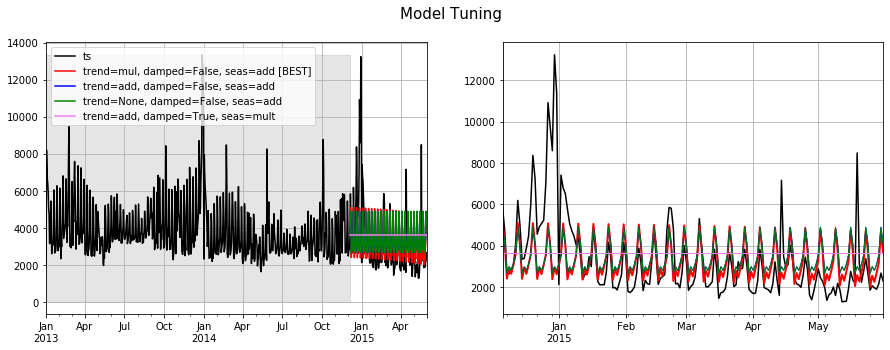

,combo,score,model
0,"trend=mul, damped=False, seas=add",1164.044943,<statsmodels.tsa.holtwinters.HoltWintersResult...
1,"trend=add, damped=False, seas=add",1294.336727,<statsmodels.tsa.holtwinters.HoltWintersResult...
2,"trend=None, damped=False, seas=add",1295.636739,<statsmodels.tsa.holtwinters.HoltWintersResult...
3,"trend=add, damped=True, seas=mult",1502.848476,<statsmodels.tsa.holtwinters.HoltWintersResult...
4,"trend=add, damped=True, seas=None",1502.848476,<statsmodels.tsa.holtwinters.HoltWintersResult...


In [16]:
# Tuning
res = tune_expsmooth_model(ts_train, s=s, val_size=0.2, scoring=metrics.mean_absolute_error, top=4, figsize=(15,5))
res.head()

Seasonal parameters: multiplicative Seasonality every 7 observations
--- computing confidence interval ---


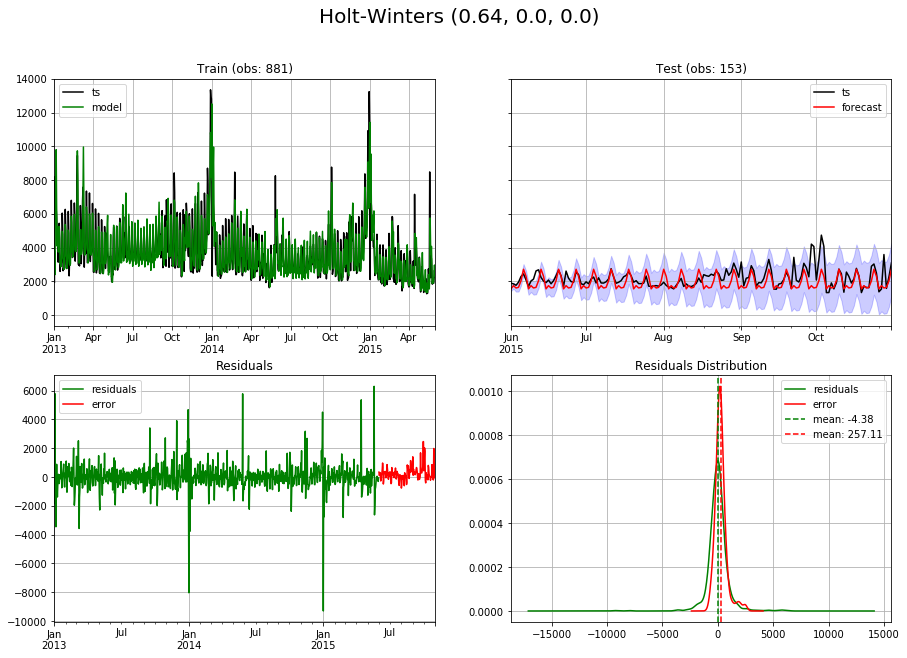

Training --> Residuals mean: -4.0  | std: 959.0
Test --> Error mean: 257.0  | std: 517.0  | mae: 388.0  | mape: 16.0 %  | mse: 331720.0  | rmse: 576.0


In [13]:
# Train/Test
dtf, model = fit_expsmooth(ts_train, ts_test, trend="additive", damped=False, seasonal="multiplicative", s=s,
                           factors=(None,None,None), conf=0.10, figsize=(15,10))

In [19]:
#-> On forecasting, the average error of prediction in 388 unit of sales (16% of the predicted value).

--- generating index date --> start: 2015-11-01 00:00:00 | end: 2016-01-01 00:00:00 | len: 62 ---
--- computing confidence interval ---


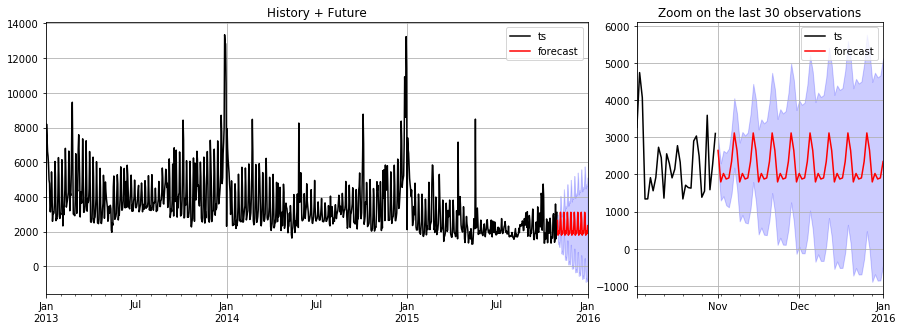

In [20]:
# Forecast unknown
model = smt.ExponentialSmoothing(ts, trend="additive", damped=False, 
                                 seasonal="multiplicative", seasonal_periods=s).fit(0.64)

future = forecast_autoregressive(ts, model, end="2016-01-01", conf=0.30, zoom=30, figsize=(15,5))

In [ ]:
#-> Exp Smooth models predict that the series will keep the downtrend and there won't be any peaks next January.

###### SarimaX

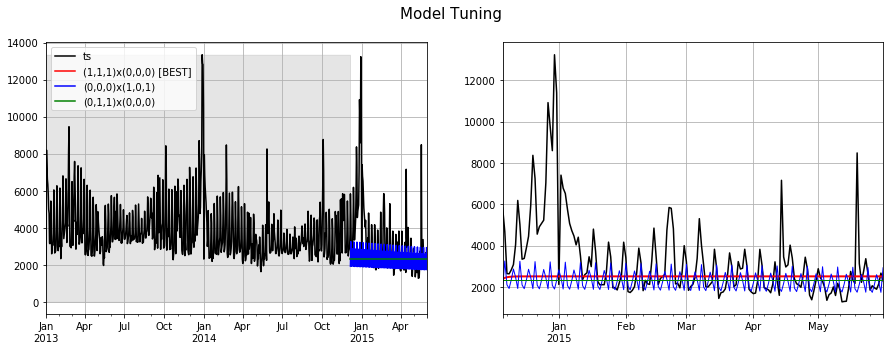

,combo,score,model
0,"(1,1,1)x(0,0,0)",1267.729997,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,"(0,0,0)x(1,0,1)",1284.688510,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,"(0,1,1)x(0,0,0)",1288.717213,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,"(1,1,0)x(0,0,0)",1293.258416,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,"(0,1,0)x(0,0,0)",1296.548023,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [17]:
# Tuning (this takes a while)
res = tune_arima_model(ts_train, s=s, val_size=0.2, max_order=(1,1,1), seasonal_order=(1,0,1),
                        scoring=metrics.mean_absolute_error, top=3, figsize=(15,5))
res.head()

In [26]:
# Tuning (this takes a while)
find_best_sarimax(ts_train, seasonal=True, stationary=False, s=s, exog=None,
                  max_p=10, max_d=3, max_q=10, 
                  max_P=1, max_D=1, max_Q=1)

best model --> (p, d, q): (1, 1, 1)  and  (P, D, Q, s): (1, 0, 1, 7)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  881
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -7268.748
Date:                           Wed, 26 Feb 2020   AIC                          14549.497
Time:                                   17:44:07   BIC                          14578.176
Sample:                                        0   HQIC                         14560.464
                                           - 881                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0045      0.005     -0.926      0.354      -0.014       0.005
ar.L1          0.6900      0.012     56.023      0.000       0.666       0.714
ma.L1         -1.0000      0.019    -51.446      0.000      -1.038      -0.962
ar.S.L7        0.9927      0.003    373.008      0.000       0.988       0.998
ma.S.L7       -0.8856      0.018    -48.105      0.000      -0.922      -0.850
sigma2      8.639e+05   2.28e-08   3.78e+13      0.000    8.64e+05    8.64e+05
===================================================================================
Ljung-Box (Q):                       52.97   Jarque-Bera (JB):              9730.31
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               2.02   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.05e+27. Standard errors may be unstable.
"""

Trend parameters: d=1
Seasonal parameters: Seasonality every 7 observations
Exog parameters: Not given


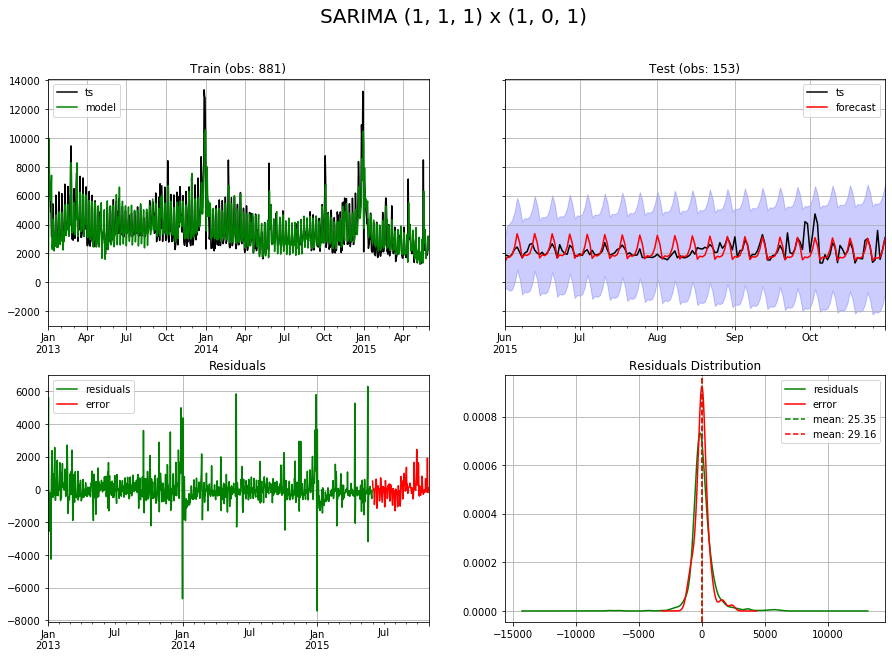

Training --> Residuals mean: 25.0  | std: 955.0
Test --> Error mean: 29.0  | std: 592.0  | mae: 394.0  | mape: 17.0 %  | mse: 348871.0  | rmse: 591.0


In [14]:
# Train/Test
dtf, model = fit_sarimax(ts_train, ts_test, order=(1,1,1), seasonal_order=(1,0,1), s=s, conf=0.95, figsize=(15,10))

In [22]:
#-> On forecasting, the average error of prediction in 394 unit of sales (17% of the predicted value).

--- generating index date --> start: 2015-11-01 00:00:00 | end: 2016-01-01 00:00:00 | len: 62 ---


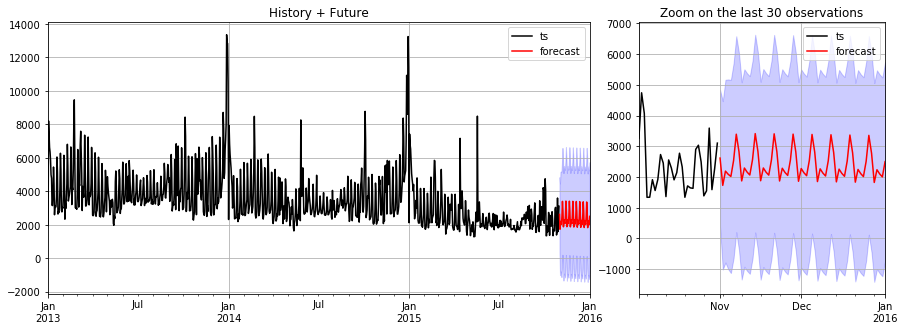

In [25]:
# Forecast unknown
model = smt.SARIMAX(ts, order=(1,1,1), seasonal_order=(1,0,1,s), exog=None).fit()

future = forecast_autoregressive(ts, model, end="2016-01-01", conf=0.95, zoom=30, figsize=(15,5))

In [ ]:
#-> Autoregressive models predict that the series will keep the downtrend and there won't be any peaks next January.

###### Garch

In [29]:
#fit_garch(ts_train, ts_test, order=(1,1,1), seasonal_order=(1,0,1,s), figsize=(15,10))

### 5 - Model Desing & Testing (Neural Network)

###### Train / Evaluate

In [5]:
# I will try to expand the memory to 1y, losing 365 days of training. This takes a while.
s = 365
n_features = 1

In [6]:
# Number of features is 1
model = models.Sequential()
model.add( layers.LSTM(input_shape=(s,n_features), units=50, activation='relu', return_sequences=True) )
model.add( layers.Dropout(0.2) )
model.add( layers.LSTM(units=50, activation='relu', return_sequences=False) )
model.add( layers.Dense(1) )
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 365, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 365, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


Seasonality: using the last 365 observations to predict the next 1
--- computing confidence interval ---


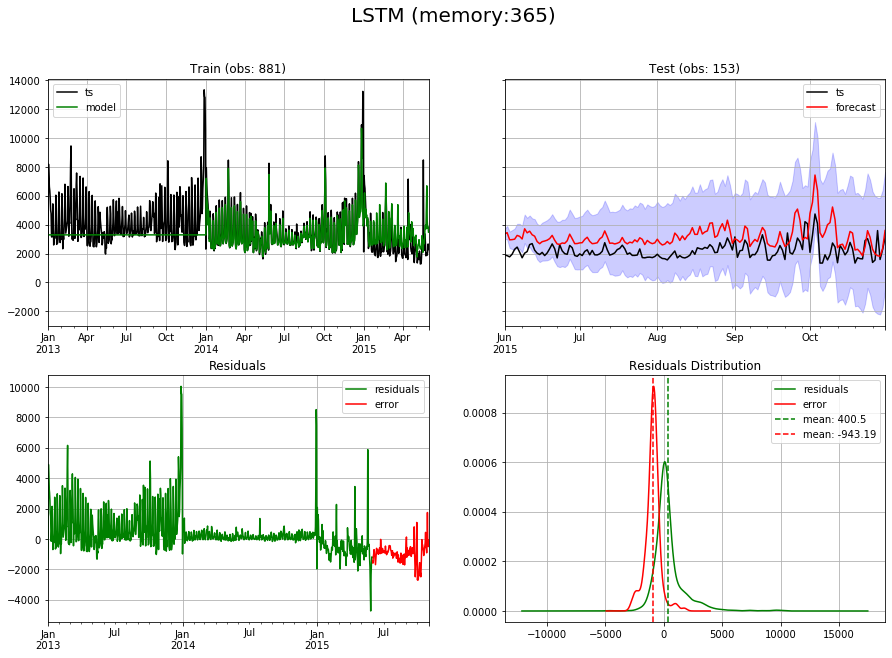

Training --> Residuals mean: 401.0  | std: 1313.0
Test --> Error mean: -943.0  | std: 629.0  | mae: 1012.0  | mape: 48.0 %  | mse: 1283261.0  | rmse: 1133.0


In [132]:
dtf, model = fit_lstm(ts_train, ts_test, model, exog=None, s=s, epochs=100, conf=0.20, figsize=(15,10))

In [129]:
#-> On forecasting, the average error of prediction in 1077 unit of sales (51% of the predicted value).

###### Forecast unknown 

--- generating index date --> start: 2015-11-01 00:00:00 | end: 2016-01-01 00:00:00 | len: 62 ---
--- computing confidence interval ---


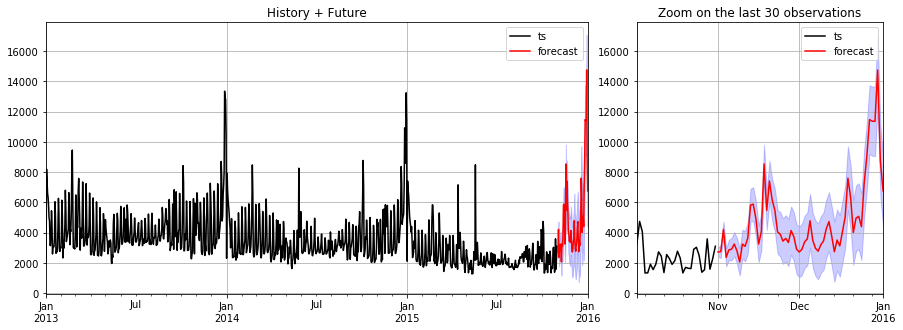

In [130]:
future = forecast_lstm(ts, model, conf=0.20, end="2016-01-01", zoom=30, figsize=(15,5))

In [38]:
#-> Lstm with 1y of memory predicts that the series will replicate yearly seasonality, with peaks in January.

### 6 - Model Desing & Testing (Prophet)

###### Train / Evaluate

In [18]:
# Create dataframe with columns 'ds' (dates), 'y' (values), 'cap' (capacity if growth="logistic"), 
# other additional regressor
dtf_train = ts_train.reset_index().rename(columns={"date":"ds", "sales":"y"})
dtf_test = ts_test.reset_index().rename(columns={"date":"ds", "sales":"y"})

dtf_train.tail()

,ds,y
876,2015-05-27,1953.0
877,2015-05-28,1885.0
878,2015-05-29,2146.0
879,2015-05-30,2665.0
880,2015-05-31,2283.0


In [19]:
# Create Holidays dataFrame with columns 'ds' (dates) and 'holiday' (string ex 'xmas')
dtf_holidays = None

In [20]:
model = Prophet(growth="linear", changepoints=None, n_changepoints=25, seasonality_mode="multiplicative",
                yearly_seasonality="auto", weekly_seasonality="auto", daily_seasonality=False,
                holidays=dtf_holidays, interval_width=0.80)

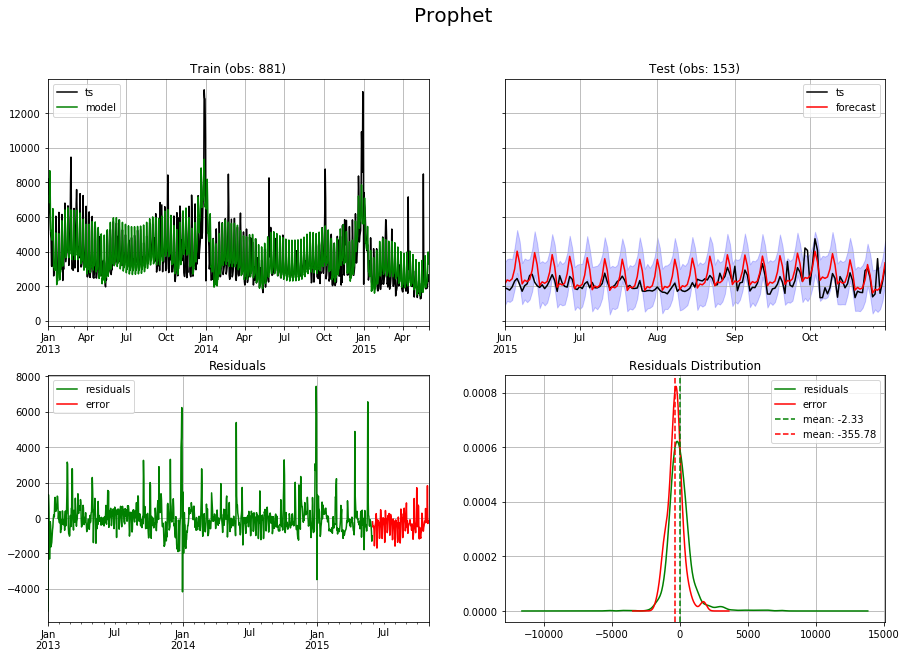

Training --> Residuals mean: -2.0  | std: 963.0
Test --> Error mean: -356.0  | std: 581.0  | mae: 534.0  | mape: 25.0 %  | mse: 461781.0  | rmse: 680.0


In [21]:
dtf, model = fit_prophet(dtf_train, dtf_test, model=model, figsize=(15,10))

In [22]:
#-> On forecasting, the average error of prediction in 534 unit of sales (25% of the predicted value).

###### Forecast unknown 

In [23]:
dtf = ts.reset_index().rename(columns={"date":"ds", "sales":"y"})
dtf.tail()

,ds,y
1029,2015-10-27,1551.0
1030,2015-10-28,3593.0
1031,2015-10-29,1589.0
1032,2015-10-30,2274.0
1033,2015-10-31,3104.0


In [24]:
model = Prophet(growth="linear", changepoints=None, n_changepoints=25, seasonality_mode="multiplicative",
                yearly_seasonality="auto", weekly_seasonality="auto", daily_seasonality=False,
                holidays=dtf_holidays, interval_width=0.80)

--- generating index date --> start: 2015-11-01 00:00:00 | end: 2016-01-01 00:00:00 | len: 62 ---


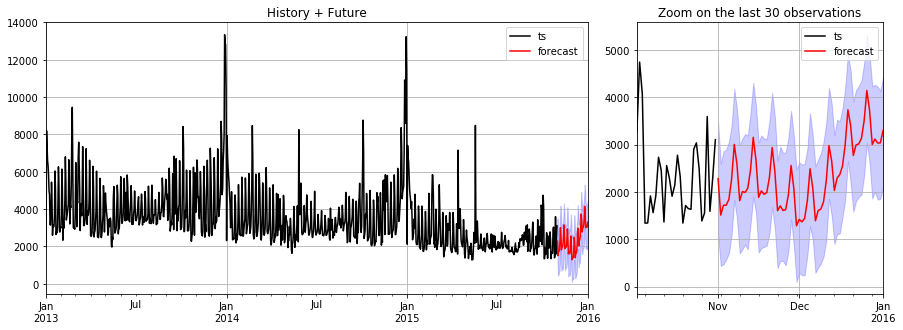

In [25]:
future = forecast_prophet(dtf, model, end="2016-01-01", zoom=30, figsize=(15,5))

In [46]:
#-> Prophet predicts that the series will keep the downtrend but includes yearly seasonality, 
#   with samller peaks in January.

### 7 - Model Desing & Testing (Custom Model)

###### Train / Evaluate

--- generating index date --> start: 2014-12-06 00:00:00 | end: 2015-05-30 00:00:00 | len: 176 ---


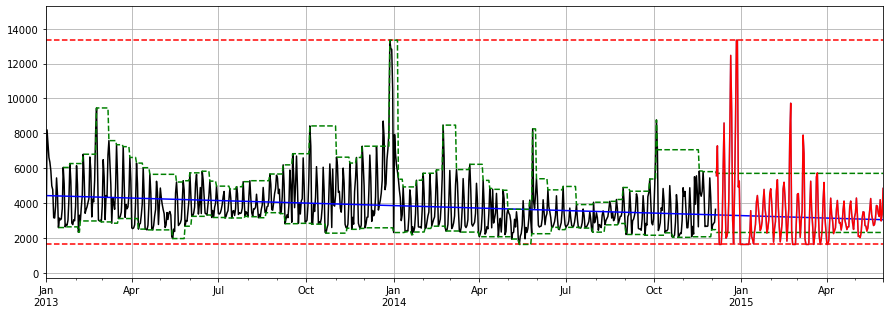

In [12]:
# Tuning
tune = custom_model(ts_train.head(int(0.8*len(ts_train))), pred_ahead=int(0.2*len(ts_train)), 
                    trend=True, seasonality_types=["dow","dom","doy","woy","moy"], 
                    level_window=7, sup_res_windows=(365,365), floor_cap=(True,True), 
                    plot=True, figsize=(15,5))

In [29]:
trend = True
seasonality_types = ["dow","dom","doy","woy","moy"]
level_window = 7
sup_res_windows = (365,365)
floor_cap = (True,True)

--- generating index date --> start: 2015-06-01 00:00:00 | end: 2015-10-31 00:00:00 | len: 153 ---
--- computing confidence interval ---


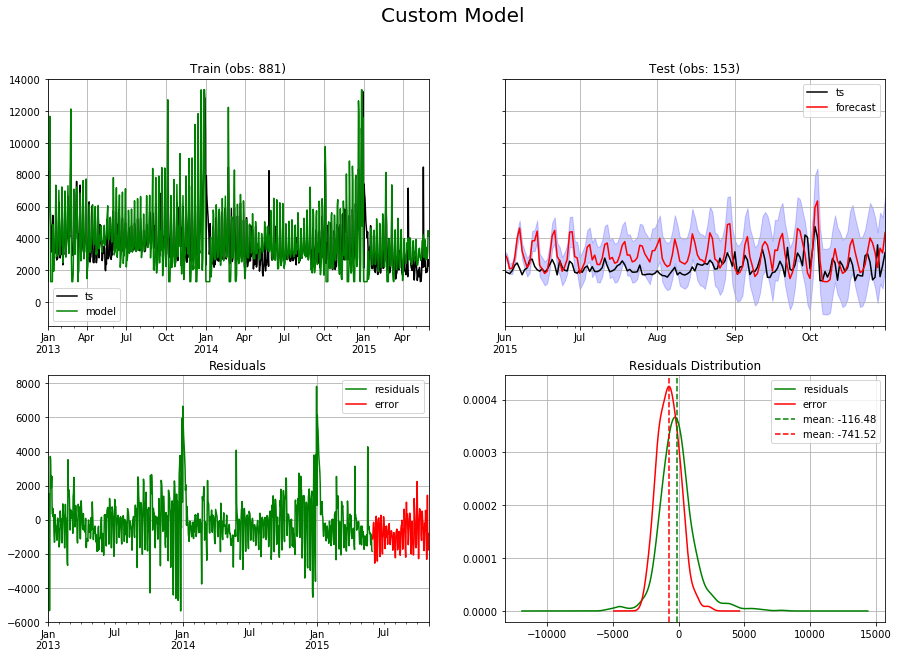

Training --> Residuals mean: -116.0  | std: 1398.0
Test --> Error mean: -742.0  | std: 851.0  | mae: 930.0  | mape: 44.0 %  | mse: 1269838.0  | rmse: 1127.0


In [30]:
dtf = fit_custom_model(ts_train, ts_test, trend, seasonality_types, level_window, sup_res_windows, floor_cap,
                       conf=0.1, figsize=(15,10))

###### Forecast unknown 

--- generating index date --> start: 2015-11-01 00:00:00 | end: 2016-01-01 00:00:00 | len: 62 ---
--- generating index date --> start: 2015-11-01 00:00:00 | end: 2016-01-01 00:00:00 | len: 62 ---
--- computing confidence interval ---


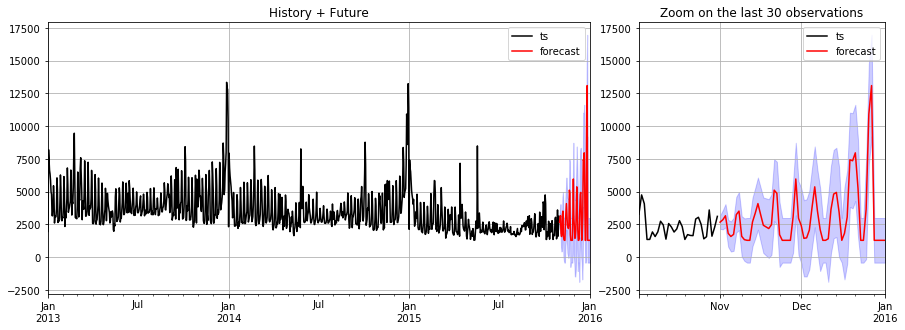

In [31]:
future = forecast_custom_model(ts, trend, seasonality_types, level_window, sup_res_windows, floor_cap,
                               conf=0.3, end="2016-01-01", zoom=30, figsize=(15,5))